# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

In this section, I will create a transcript generator.

# Table of Contents

* Data Processing
    * 0.1 [Loading data](#data-loading)
    * 0.2 [Example transcript](#data-example)
    * 0.3 [Encoding transcripts](#data-encoding)
    * 0.4 [Building a training set](#data-train)
* Markov Model
    * 1.1 [Markov Chain](#markov)
* RNN Modeling
    * 2.1 [Model Architecture](#rnn-initialize)
    * 2.2 [Model training](#rnn-train)
    * 2.3 [Model testing](#rnn-test)
* Attention Network Modeling
    * 3.1 [Model Architecture](#attn-initialize)
    * 3.2 [Model training](#attn-train)
    * 3.3 [Model testing](#attn-test)

# Section 0: Initial data processing

## 0.1 Loading the data <a name="loading"></a>
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts.

In [1]:
# Importing the libraries I'll be using
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mysql.connector
import re
from sklearn.preprocessing import QuantileTransformer
import time
import matplotlib.cm as cm

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}
plt.rc('font', **font)

In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

Let's go ahead and pull all of the transcripts from the database - this dataset happens to be small enough that I can load it all at once.

I also divide the transcripts randomly into testing, training, and validation sets. This will ensure that when I perform analyses, I don't build models that over-fit the data.

In [4]:
num_transcripts = 4131
transcript_df = pull_transcript(n=num_transcripts)

# split the tables into testing and training sets, so that we don't over-fit. 
np.random.seed(42) # Ensures that the split is the same each round
transcript_df['train'] = np.random.rand(num_transcripts)>.2
transcript_df['test'] = transcript_df['train']==False

# Further separate the training dataset into a training and validation set
transcript_df['val'] = (np.random.rand(num_transcripts)>.8) & (transcript_df['train'])

# ensure that the training and validation sets don't overlap
transcript_df['train'] = transcript_df['train'] & (transcript_df['val']==False)

In [5]:
transcript_df.head(10)

,episode_id,aired_at,url,segment,transcript,train,test,val
id,,,,,,,,
1,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False
2,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
3,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,bluff,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False
4,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,job,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
5,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
6,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,limerick,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
7,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,lightning,"\n \n \n \n\n PETER SAGAL, HOS...",False,True,False
8,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,predictions,"\n \n \n \n\n PETER SAGAL, HOS...",True,False,False
9,2,2019-04-27,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...,True,False,False


In [6]:
# For simplicity, I'll set all letters to lower-case
transcript_df.loc[:,'transcript'] = transcript_df.loc[:,'transcript'].str.lower()

## 0.2 Example transcript<a name="data-example"></a>

To understand the data, it helps to first see what the raw data looks like. Let's print a little bit of the transcript from the first dataset.

In [7]:
print(transcript_df.loc[1,'transcript'][:500])


    
        
    

    bill kurtis: from npr and wbez chicago, this is wait wait... don't tell me, the npr news quiz. hey, arthur miller - step into this cruci-bill (ph).
    (laughter)
    kurtis: i'm bill kurtis. and here's your host at the chase bank auditorium in downtown chicago, peter sagal.
    peter sagal, host: 
    thank you, bill. thank you, everybody.
    (cheering)
    sagal: thank you so much. we have a very interesting show for you today. later on, we're going to be talking to m


In [8]:
transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    bill kurtis: from npr and wbez chicago, this is wait wait... don't tell me, the npr news quiz. hey, arthur miller - step into this cruci-bill (ph).\n    (laughter)\n    kurtis: i'm bill kurtis. and here's your host at the chase bank auditorium in downtown chicago, peter sagal.\n    peter sagal, host: \n    thank you, bill. thank you, everybody.\n    (cheering)\n    sagal: thank you so much. we have a very interesting show for you today. later on, we're going to be talking to microsoft co-founder steve ballmer. he is, we believe, the richest guest we've ever had. but, of course, your true wealth is measured in your friends. and this just in - he has more friends, too.\n    (laughter)\n    sagal: but first, as many of you know, the npr podcast feeds got all screwed up last week. people who tried to download our show got, for example, how i built this instead, for which i apologize. and the people who wanted how i built this got us, for which i apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

## 0.3 Encoding the text <a name='data-encoding'></a>



I will be building a letter-based generator for now, so I want a way to encode both letters and punctuation as integers (eventually, to be transferred into a one-hot encoding scheme for transferring to the model).

In [502]:
from sklearn.preprocessing import OneHotEncoder

In [503]:
all_tokens = set(transcript_df.loc[transcript_df.train,'transcript'].str.cat())
print(f'The dataset includes {len(all_tokens)} unique tokens')

The dataset includes 77 unique tokens


In [504]:
# Make a dictionary converting letters/punctuation to integers
conversion_dict = {}
for i, token in enumerate(all_tokens):
    conversion_dict[token] = i
    
# Make a second dictionary to go in the other direction
reversion_dict = dict( (v,k) for k, v in conversion_dict.items() )

In [505]:
# simple function to encode transcript
def encode_transcript(transcript):
    return [conversion_dict.get(n,len(all_tokens)) for n in transcript]
def decode_transcript(transcript):
    return [reversion_dict.get(n,len(all_tokens)) for n in transcript]

In [506]:
# Encode each of the transcripts by converting letters and punctuation to integers
transcript_df['encoded'] = transcript_df.loc[:,'transcript'].apply(encode_transcript)

In [507]:
transcript_df.head()

,episode_id,aired_at,url,segment,transcript,train,test,val,encoded,encoded_words
id,,,,,,,,,,
1,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n bill kurtis: fro...,True,False,False,"[3, 33, 33, 33, 33, 3, 33, 33, 33, 33, 33, 33,...","[88, 78, 39, 21, 6, 336, 161, 17, 11, 44, 44, ..."
2,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n peter sagal, hos...",True,False,False,"[3, 33, 33, 33, 33, 3, 33, 33, 33, 33, 33, 33,...","[84, 2, 107, 23, 63, 317, 27, 102, 14, 7, 5, 2..."
3,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,bluff,\n \n \n \n\n bill kurtis: fro...,True,False,False,"[3, 33, 33, 33, 33, 3, 33, 33, 33, 33, 33, 33,...","[88, 78, 39, 21, 6, 336, 161, 17, 11, 44, 44, ..."
4,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,job,"\n \n \n \n\n peter sagal, hos...",True,False,False,"[3, 33, 33, 33, 33, 3, 33, 33, 33, 33, 33, 33,...","[84, 2, 107, 6, 63, 1, 119, 144, 3659, 81, 243..."
5,1,2019-05-04,https://www.npr.org/templates/transcript/trans...,panel,"\n \n \n \n\n peter sagal, hos...",False,True,False,"[3, 33, 33, 33, 33, 3, 33, 33, 33, 33, 33, 33,...","[84, 2, 107, 23, 63, 317, 117, 99, 255, 14, 7,..."


In [508]:
# Generate a one-hot encoder to finally yield data in a one-hot version
onehotencoder = OneHotEncoder(categories='auto',sparse=False)
onehotencoder.fit(np.concatenate(transcript_df.encoded.values).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [509]:
# Define a function to apply the one hot scheme to the integer-encoded values
def one_hot_transcript(transcript):
    integer_transcript = np.array(encode_transcript(transcript)).reshape(-1,1)
    return onehotencoder.transform(integer_transcript)

In [510]:
# Convert the encoded transcript values to the one-hot encodings
transcript_df['encoded'] = transcript_df.loc[:,'transcript'].apply(one_hot_transcript)

## 0.5 Data Generator
This is a different way of making the data. Doing the massive conversion of transcript to one-hot encoding is pretty memory-intensive. One way to improve that is to only process some of the data at a time, using a generator. This could also enable me to add some additional randomization into my process, so I'm going to play around with it. This code is closely based on the tutorial here: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [530]:
# parameters
n_times = 100
n_components = len(all_tokens)+1
batch_size = 64

In [531]:
import keras
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, df, batch_size=batch_size,n_times=n_times,n_components=n_components,shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.df = df.encoded
        self.indices = np.copy(self.df.index.values)
        self.dim = (batch_size,n_times,n_components)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return len(self.df.index.values)

    def __getitem__(self, index):

        # Generate data
        X, y = self.__data_generation(self.indices[index])

        return X, y

    def __data_generation(self, transcript_num):
        #'Generates data containing batch_size samples' 
        # Initialization
        X = np.empty(self.dim)
        y = np.empty((self.batch_size,self.dim[-1]), dtype=int)

        # Pull batch_size random samples from the specified transcript
        indices = np.random.randint(low=0,
                                    high=self.df[transcript_num].shape[0]-n_times-1,
                                    size=self.batch_size)
        
        # for each start position, pull a sequence of n_times chars for X, and the next char for y
        for i, startpos in enumerate(indices):
            # Store sample
            X[i,] = self.df[transcript_num][startpos:startpos+n_times,:]

            # Store class
            y[i] = self.df[transcript_num][startpos+n_times,:]

        return X, y

In [532]:
train_gen = DataGenerator(transcript_df.loc[transcript_df.train,:],shuffle=False)
val_gen = DataGenerator(transcript_df.loc[transcript_df.val,:],shuffle=False)

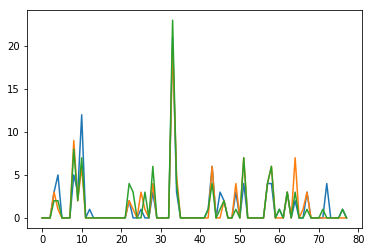

In [533]:
plt.plot(train_gen.__getitem__(0)[0][0].sum(axis=0))
plt.plot(train_gen.__getitem__(0)[0][0].sum(axis=0))
plt.plot(train_gen.__getitem__(0)[0][0].sum(axis=0))


# 1.0 Markov Chain <a name="markov"></a>
As a control, let's build a very simple system, called a "Markov chain." This system simply calculates the probability of a next character, given the previous characters (how many previous characters is a selectable parameter). It then generates text by sampling this probability matrix. We can compare the performance of the Markov chain with the performance of the neural networks we build later.

This code initialized with the tutorial provided here: https://eli.thegreenplace.net/2018/elegant-python-code-for-a-markov-chain-text-generator/

In [515]:
from collections import defaultdict, Counter
import random

# This is the length of the "state" the current character is predicted from.
STATE_LEN = 15

In [516]:
# join all transcripts together
data = transcript_df.loc[:,'transcript'].str.cat()


In [517]:
# initialize model
markovmodel = defaultdict(Counter)
print('Learning model...')
for i in range(len(data) - STATE_LEN):
    state = data[i:i + STATE_LEN]
    nxt = data[i + STATE_LEN]
    markovmodel[state][nxt] += 1
    if i%10000000 ==0:
        print(f'{i}/{len(data)}')

Learning model...
0/31012208
10000000/31012208
20000000/31012208
30000000/31012208


In [518]:
print('Sampling...')
state = random.choice(list(markovmodel))
out = state
for i in range(1000):
    out += random.choices(list(markovmodel[state]), markovmodel[state].values())[0]
    state = out[-STATE_LEN:]
print(out)

Sampling...
 mr. burbank: because, like, the end of the world have some special feature - the low income tenants will get their very own.
    (laughter)
    sagal: ...of the squirrel in the motor. 
    sagal: right.
    (soundbite of laughter) 
    mr. bodett: you know, the saddle is throwing you and stuff...
    poundstone: there you go.
    sagal: i know, mo, i've said this before on this program for kids.
    (soundbite of laughter)
    (soundbite of bell)
    sagal: that was john boehner said he was a monk."
    (laughter)
    bodden: her tv. no idea.
    sagal: right.
    (soundbite of bell)
    sagal: it's true.
    (soundbite of laughter)
    m: because he wasn't talking to the super bowl, the denver broncos, washington state used a bow and arrow. scientists tested this milk substance, and they found him behind the wheel. so you can blame it for anything. it's not like a state occasion or an official occasion. like he pays for his kids' rice crispies, that's, like, america's you

### Markov Chain conclusions
Because the Markov chain samples from the distribution of previously-seen phrases, everything that it says sounds like language. Phrases even make sense for short durations, but rarely over long ones, due to the fact that it only uses a set amount of past characters to generate future characters. So it does an OK job, but certainly doesn't make anything that truly sounds like language.

## 2.0 Recurrent Neural Network Model <a name='rnn-initialize'></a>

### Generate transcript function
First, specify a function that, given a model and a sample of text, will generate the next text for the transcript. We'll run this function occasionally in order to visualize how our model learning is progressing.

In [534]:
def Predict_transcript(model,generator,chars_to_generate=50):
    sample = generator.__getitem__(np.random.randint(500))[0][np.random.randint(batch_size)]
    sample = sample.reshape(1,sample.shape[0],sample.shape[1])
    
    # initialize the phrase
    predicted_phrase = np.concatenate((sample,np.zeros((1,chars_to_generate,n_components))),axis=1)

    for char in range(n_times,n_times+chars_to_generate):
        # calculate the probability distribution
        probability = model.predict(sample).squeeze()

        # guess the next character and add it to our prediction
        guess = np.random.choice(a=n_components,p=probability)
        predicted_phrase[0,char,guess] = 1

        # feed the results into the next step of the model
        sample = predicted_phrase[:,(char+1-n_times):char+1,:]

    # Convert to text
    predicted_phrase = ''.join(decode_transcript(np.argmax(predicted_phrase,axis=-1).squeeze()))
    
    # output the phrase
    return predicted_phrase
    

I'm going to use a recurrent neural network (GRU) to generate my text. There are other systems I would also like to play with in the future (e.g. Markov models, transformer network), but this will make a good start.

In [520]:
# Sequential models are pretty simple, I'll start there.
from keras.models import Model
from keras.layers import GRU,Dense,Bidirectional,Input,Add,Dropout,SpatialDropout1D,GlobalAveragePooling1D,BatchNormalization
from keras.callbacks import Callback
from keras.optimizers import Adam,Nadam

# Later on I'm going to try out some attention
# for speed at the moment, I'll use attention layers that have already been written
from keras_self_attention import SeqSelfAttention # source: https://github.com/CyberZHG/keras-self-attention

In [521]:
# parameter setting
n_units = 128 # size of RNN layers

# helper function to add in a middle GRU layer and sum the outputs+inputs to that layer
def Add_GRU_layer(inp,n_units):
    mid = Bidirectional(GRU(n_units,activation='tanh',input_shape=(n_times,n_components),return_sequences=True))(inp)
    mid = SeqSelfAttention(attention_activation='sigmoid')(mid)
    final = Add()([mid,inp])
    final = BatchNormalization()(final)
    return final

# helper function to incorporate attention

## Model layer definitions start here
x_in = Input(shape=(n_times,n_components))

# GRU layer
x = Bidirectional(GRU(n_units,activation='tanh',input_shape=(n_times,n_components),return_sequences=True))(x_in)
x = SeqSelfAttention(attention_activation='sigmoid')(x)

# middle layers, with skip-gram combinations & attention
for mid_layer in range(1):
    x = Add_GRU_layer(x,n_units)

# final layer, average over time
x = GlobalAveragePooling1D()(x)
x = Dropout(rate=0.25)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(rate=0.25)(x)
dense_out = Dense(n_components,activation='softmax')(x)

optimizer = keras.optimizers.RMSprop()
model = Model(inputs=[x_in],outputs=[dense_out])
model.compile(loss='categorical_crossentropy',optimizer=optimizer)

In [501]:
# Generate a model summary to visualize the layers and model size
model.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 10, 78)            0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 10, 256)           158976    
_________________________________________________________________
seq_self_attention_13 (SeqSe (None, 10, 256)           16449     
_________________________________________________________________
global_average_pooling1d_51  (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_230 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0  

### 2.2 Train the model<a name='rnn-train'></a>

In [537]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)
n_epochs = 3
decay_rate = 1/(sum(transcript_df.train)*n_epochs)

for lr in [0.01,0.005,0.001,0.0005,0.0001]:
    optimizer=keras.optimizers.RMSprop(lr=lr,decay=decay_rate)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer)
    history = model.fit_generator(train_gen,
                                  epochs=n_epochs,
                                  validation_data = val_gen,
                                  validation_steps = sum(transcript_df.val),
                                  steps_per_epoch=sum(transcript_df.train),
                                  callbacks = [early_stopping])
    print(Predict_transcript(model,val_gen,chars_to_generate=100));
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


Epoch 1/3
2639/2639 [==============================] - 904s 342ms/step - loss: 2.4362 - val_loss: 2.2565
Epoch 2/3
2639/2639 [==============================] - 906s 343ms/step - loss: 2.3492 - val_loss: 2.1829
Epoch 3/3
2639/2639 [==============================] - 877s 332ms/step - loss: 2.3003 - val_loss: 2.1667
r news quiz. i'm bill kurtis. and here is your host at the chase bank auditorium in downtown chicagoc rogpet lirram? fairi.. od, lodginrre. tharode kat ghoteridgaen leiwrirylisbaatam ak
    het
    re
Epoch 1/3
2639/2639 [==============================] - 926s 351ms/step - loss: 2.2334 - val_loss: 2.0935
Epoch 2/3
2639/2639 [==============================] - 879s 333ms/step - loss: 2.2271 - val_loss: 2.0714
Epoch 3/3
2639/2639 [==============================] - 847s 321ms/step - loss: 2.2109 - val_loss: 2.0501
nd an owl makes and nothing else.
    goldthwait: so it's hooters.
    sagal: but for...
    goldthwh.ecis. rei pifisad: oi a: fagats a'nrt tond that.. idly..
    parpar

KeyboardInterrupt: 

In [178]:
model_path = './GRU_Text_Generator2'
model.save(model_path)

In [186]:
model = keras.models.load_model(model_path, custom_objects=SeqSelfAttention.get_custom_objects())

### 2.3 Assess performance<a name='rnn-test'></a>

In [273]:
print(Predict_transcript(model,val_gen,chars_to_generate=100));

one: how will they know? i mean, don't you just buy a ticket and go in?
    (laughter)
    bodden: he'll. allny, fonts, amores the ars the, couldersfar blanidiesns?
    sagal: po amber do e it's lay w


This network is doing ok, but nothing to write home about at the moment. We get a couple of "real" words, and the included punctuation looks reasonable. However, the final result is not recognizable English. This suggests to me that the network likely needs more training time, or possibly more units or more training data.

### Attention network <a name='attn-initialize'></a>

In [274]:
import keras
from keras_multi_head import MultiHeadAttention,MultiHead

In [279]:
layer_size = 128

# Function to add a set of layers that together make up a "transformer"
def Add_Transformer(inp_layer,head_num=16):
    att_layer = MultiHeadAttention(
        head_num=head_num,
        activation='sigmoid',
    )(inp_layer)

    summed = keras.layers.Add()([embedded,att_layer])
    normed = BatchNormalization()(summed)
    
    # follow each attention layer with a feed-forward layer
    feed_forward = Dense(layer_size)(normed)
    normed = BatchNormalization()(feed_forward)
    
    return normed

# Start building layers
input_layer = keras.layers.Input(
    shape=(n_times, n_components),
    name='Input',
)
embedded = keras.layers.TimeDistributed(Dense(layer_size))(input_layer)
embedded = SpatialDropout1D(rate=0.25)(embedded)

# Transformer 1
x = Add_Transformer(embedded)
x = SpatialDropout1D(rate=0.25)(x)

# Transformer layer 2
for layer in range(1):
    x = Add_Transformer(x)

# readout
flattened = keras.layers.GlobalAveragePooling1D()(x)
flattened = Dropout(rate=0.25)(flattened)
dense_out = Dense(n_components,activation='softmax')(flattened)

model2 = keras.models.Model(inputs=input_layer, outputs=dense_out)
model2.compile(
    optimizer='nadam',
    loss='categorical_crossentropy',
)

model2.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 100, 78)      0                                            
__________________________________________________________________________________________________
time_distributed_12 (TimeDistri (None, 100, 128)     10112       Input[0][0]                      
__________________________________________________________________________________________________
spatial_dropout1d_55 (SpatialDr (None, 100, 128)     0           time_distributed_12[0][0]        
__________________________________________________________________________________________________
multi_head_attention_54 (MultiH (None, 100, 128)     66048       spatial_dropout1d_55[0][0]       
___________________________________________________________________________________________

## 3.2 Train the attention model <a name='attn-train'></a>

In [281]:
# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)
history = model2.fit_generator(train_gen,
                              epochs=100,
                              validation_data = val_gen,
                              validation_steps = sum(transcript_df.val),
                              steps_per_epoch=sum(transcript_df.train),
                              callbacks = [early_stopping])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Epoch 1/100
2639/2639 [==============================] - 737s 279ms/step - loss: 3.0500 - val_loss: 2.9940
Epoch 2/100
 506/2639 [====>.........................] - ETA: 9:10 - loss: 3.0062

KeyboardInterrupt: 

## 3.3 Assess attention model performance <a name='attn-test'></a>

In [ ]:
model2.evaluate_generator(val_gen)
print(Predict_transcript(model2, val_gen,chars_to_generate=100));

# 4.0 Word-based model
Looks like the letter-based models are pretty hard to get accurate, especially given that at the moment I am only running on a CPU. I wonder if a word-based model would perform better, given that the thorny "first learn English" problem is less of a worry. To do this, I'll need to process the inputs differently. Let's see what I can do.

**Edit**: I realized a subtle bug that I had in my character training/validation generator function above, such that selections were being repeated from epoch to epoch. I have fixed it, and will go back soon and see if things improve once I'm actually training on more of my training data.

## 4.1 Processing Input

We'll need to "tokenize" the input, e.g. convert words into numbers

In [369]:
# import the tokenizer class, specify vocabulary size
from keras.preprocessing.text import Tokenizer
n_words = 10000

# build and train a tokenizer instance
tokenizer = Tokenizer(num_words=n_words)
tokenizer.fit_on_texts(transcript_df.transcript)

# tokenize our texts
transcript_df['encoded_words'] = tokenizer.texts_to_sequences(transcript_df.transcript)

So that we don't have to re-invent the wheel, I'll also use GLOVE embeddings to incorporate some fore-knowledge of word similarities into my model.

In [370]:
BASE_DIR = './'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
EMBEDDING_DIM = 50

# Make the embedding matrix
def Make_embedding_matrix(tokenizer):
    word_index = tokenizer.word_index
    # Create a dictionary mapping words to GLOVE embeddings
    print('Indexing word vectors.')
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
    
    # Prepare embedding matrix
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > n_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [371]:
embedding_matrix = Make_embedding_matrix(tokenizer)

Indexing word vectors.
Found 400000 word vectors.


### Make a generator
As before, we'll want to make a generator to make data to feed our networks.

In [485]:
class DataGenerator_words(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, df, batch_size=batch_size,n_times=n_times,n_components=n_words,shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.df = df.encoded_words
        self.indices = np.copy(self.df.index.values)
        self.dim = (batch_size,n_times)
        self.shuffle = shuffle
        self.n_components = n_components
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return len(self.df.index.values)

    def __getitem__(self, index):

        # Generate data
        X, y = self.__data_generation(self.indices[index])

        return X, y

    def __data_generation(self, transcript_num):
        #'Generates data containing batch_size samples' 
        
        
        # timing signal so that the network can figure out how to use longer times
        timing_signal = np.sin(np.repeat(np.arange(n_times).reshape(-1,1),10,axis=1)/np.arange(1,11)).reshape(1,n_times,10)
        timing_signal = np.repeat(timing_signal,batch_size,axis=0)
        # start from last word, so that encoding for later words is consistent as duration increases
        timing_signal = timing_signal[:,::-1,:] 
        
        # Initialization
        X = np.empty(self.dim)
        y = np.zeros((self.batch_size,self.n_components), dtype=int)

        # Pull batch_size random samples from the specified transcript
        indices = np.random.randint(low=0,
                                    high=len(self.df[transcript_num])-n_times-1,
                                    size=self.batch_size)
        
        # for each start position, pull a sequence of n_times chars for X, and the next char for y
        for i, startpos in enumerate(indices):
            # Store sample
            X[i,] = self.df[transcript_num][startpos:startpos+n_times]

            # Store next word
            y[i, self.df[transcript_num][startpos+n_times]] = 1 # one-hot encoding
        
        X = [X,timing_signal]

        return X, y

n_times=10
train_gen = DataGenerator_words(transcript_df.loc[transcript_df.train,:],shuffle=True,n_times=n_times)
val_gen = DataGenerator_words(transcript_df.loc[transcript_df.val,:],shuffle=True,n_times=n_times)

## 4.2 Attention model

In [497]:
embedding_matrix.shape

(54080, 50)

In [495]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.initializers import Constant
from keras_layer_normalization import LayerNormalization

layer_size = 512
head_num = 8

sequence_input = Input(shape=(n_times,),
                           dtype='int32',name='Words')
timing_input = Input(shape=(n_times,10),name='times')

# embedded = Embedding(embedding_matrix.shape[0],
#                             embedding_matrix.shape[1],
# #                             embeddings_initializer=Constant(embedding_matrix),
#                             input_length=None,
#                             trainable=False)(sequence_input)
embedded = Embedding(n_words,
                            embedding_matrix.shape[1],
#                             embeddings_initializer=Constant(embedding_matrix),
                            input_length=None,
                            trainable=False)(sequence_input)
 = Dense()(embedded)

# add in a timing signal
x = keras.layers.Concatenate()([x,timing_input])

# Multi-head attention layer
attn = MultiHeadAttention(head_num=head_num,activation='sigmoid')(x)
summed = Add()([x,attn])
normed = LayerNormalization()(summed)

# Feed-forward layer
x = Dense(layer_size,activation='relu')(normed)
summed = Add()([x,normed])
normed = LayerNormalization()(summed)
normed = SpatialDropout1D(rate=0.25)(normed)

# Multi-head attention layer
for mid_layers in range(1):
    attn = MultiHeadAttention(head_num=head_num,activation='sigmoid')(normed)
    summed = Add()([normed,attn])
    normed = LayerNormalization()(summed)

    # Feed-forward layer
    x = Dense(layer_size,activation='relu')(normed)
    summed = Add()([x,normed])
    normed = LayerNormalization()(summed)
    normed = SpatialDropout1D(rate=0.25)(normed)

# Final readout
pooled = keras.layers.Flatten()(normed)
linear = Dense(layer_size,activation='relu')(pooled)
readout = Dense(n_words,activation='softmax')(linear)


# compile the model
optimizer = keras.optimizers.RMSprop(decay=0.001)
model = Model(inputs=[sequence_input,timing_input],outputs = readout)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
)

model.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Words (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 10, 50)       2704000     Words[0][0]                      
__________________________________________________________________________________________________
dense_225 (Dense)               (None, 10, 502)      25602       embedding_77[0][0]               
__________________________________________________________________________________________________
times (InputLayer)              (None, 10, 10)       0                                            
___________________________________________________________________________________________

In [496]:
def Predict_words(model,val_gen,n_words_to_predict=10):
    inp = val_gen.__getitem__(np.random.randint(sum(transcript_df.val)))[0][0]
    predicted_text = inp[np.random.randint(batch_size)].reshape(1,-1)
    for word in range(n_words_to_predict):
        predicted_token = np.random.choice(a=n_words,size=1,p=model2.predict(predicted_text)[0]).reshape(1,1)
        predicted_text = np.concatenate((predicted_text,predicted_token),axis=-1)
    print(tokenizer.sequences_to_texts(predicted_text)[0])

In [489]:
class PredictionCallback(keras.callbacks.Callback):
    
    def on_epoch_end(x,y,z):
        Predict_words(model,val_gen)

In [494]:
# progressively learn longer strings
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
batch_size = 64

for n_times in range(10,100,10):
    train_gen = DataGenerator_words(transcript_df.loc[transcript_df.train,:],shuffle=True,n_times=n_times,batch_size=batch_size)
    val_gen = DataGenerator_words(transcript_df.loc[transcript_df.val,:],shuffle=True,n_times=n_times,batch_size=batch_size)
    
    history = model.fit_generator(train_gen,
                              epochs=5,
                              validation_data = val_gen,
                              validation_steps = sum(transcript_df.val),
                              steps_per_epoch=sum(transcript_df.train),
                              callbacks = [early_stopping,PredictionCallback()])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

Epoch 1/5
1589/2639 [=================>............] - ETA: 3:54 - loss: 5.8593

KeyboardInterrupt: 

In [484]:
Predict_words(model,val_gen)

o'clock you got him yep i got him i'm following wait wait he's a white guy he's a white guy hold fire stand down peaceful laughter jobrani tell it like it is my brother sagal i know jobrani as the iranian i appreciate you saying that laughter salie no this these are is pair soundbite wondered a go soundbite their


In [396]:
timing_signal.shape

(10, 20)